# Partial Default Simulation and Plots

This runs the example in the paper ["Partial Default and Government Reputation"](https://manuelamador.me/files/reputationpartial.pdf) by Manuel Amador and Christopher Phelan. 

In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))
Pkg.instantiate() 
using Revise

  Activating project at `C:\Users\amado\Documents\GitHub\partial_default`


In [2]:
includet(joinpath(@__DIR__, "..", "src", "partial_default.jl"));

## Example in the paper

In [3]:
m = FixedHaircutsModel(
    bmin = 0.01,
    η_grid = [0.25, 0.75], 
    θn = [0.005, 0.005] 
)

FixedHaircutsModel{Float64, Vector{Float64}, Vector{Float64}, Int64}(0.15, 0.01, 0.2, 0.02, 0.01, 1.0, 1.0, [0.25, 0.75], [0.005, 0.005], 2, 0.01)

In [4]:
@time sol = solve(m, c_range = BigFloat[1.002, 1.05]);

.............................................................................................................................................................................................................................................................. 82.207005 seconds (405.14 M allocations: 22.357 GiB, 7.76% gc time, 65.56% compilation time)


In [5]:
sol.T

30.87828187321413164441124099375422491015227893196667051029278021661461055781113

In [6]:
sol.cstar

1.002633828143189411323343777144673645981814298405882562139830998996173379863195

## Plots

In [7]:
using Plots

# Using PGF plots 
pgfplotsx(); 
default(labels = "", lw = 3, color = :black) 


In [8]:
function do_plots(s; tmax = 100)
    tspan = collect(range(0, tmax, length=200))
    q_list = [s.q(t) for t in tspan]

    f1 = plot()
    f2 = plot()
    f3 = plot()
    f4 = plot()

    plot!(f1, [(t, q) for (t, q) in zip(tspan, q_list) if 0 < q < 1], 
    title = L"Bond price, $q(t)$", xlim = (0, tmax))
    plot!(f2, tspan, [s.b(t) for t in tspan], title = L"Debt level, $b(t)$")
    plot!(f3, tspan, [s.ρ(t) for t in tspan], title = L"Reputation, $\rho(t)$")
    plot!(f4, [(t, get_c(s, t)) for t in tspan if 0 < get_c(s, t) < 1.2], 
            title = L"Consumption, $c(t)$", xlim = (0, tmax))
        
    for f in (f1, f2, f3, f4)
        vline!(f, [s.T], color = :gray, lw = 2.0)
        # xlabel!(f, "time")
        xticks!(f, [0, 20, 40, 60, 80, 100, s.T], ["0", "20", "40", "60", "80", "100", "T"])
    end

    plot(f1, f2, f3, f4, layout = (2, 2), size = 0.8 .* [900, 600])
end 


function do_conditional_default_probability_plots(s; maxT = 100, npoints = 200)
    tmax = min(maxT, s.tmax)

    f2 = plot()
    
    f3 = plot()
    
    for f in (f2, f3)
        vline!(f, [s.T], color = :gray, lw = 2.0)
        # xlabel!(f, "time")
        xticks!(f, [0, 20, 40, 60, 80, 100, s.T], ["0", "20", "40", "60", "80", "100", "T"])
    end

    γss = [(t, get_γs(s, t)) for t in range(s.T, tmax, length = npoints)]

    plot!(f2, title = L"Default probabilities, $\gamma_n(t)$", xlim = (0, tmax), ylim = (0, 0.7))

    plot!(f2, [(t, get_γ0(s, t)) for t in range(s.T, tmax, length = npoints)],
        label = L"$\gamma_0$ (full default)",
        color = :black)

    for (i, sty) in zip(1:length(γss[1][2]), (:dash, :dot))
        η = s.model.η_grid[i]
        plot!(f2, [(t, x[i]) for (t, x) in γss], 
            label = L"$\gamma_%$i (\eta = %$η$: haircut $%$(Int(100*(1-η)))%)$",
            style = sty, 
            color = :black,
            lw = 1,
            legend_style = "{at = {(0.5,0.3)}, anchor = west}", 
            extra_kwargs = :subplot
        )
    end
    
    αss = [(t, get_αs(s, t)) for t in range(0, s.T - 0.001, length = npoints)]


    plot!(f3, title = L"Arrival rates of defaults, $\alpha_n(t)$", xlim = (0, tmax), ylim = (0, 0.5))
    
    ymax = 0.5
    plot!(f3, [(t, get_α0(s, t)) for t in range(0, s.T - 0.001, length = npoints) 
                if get_α0(s, t) < ymax], 
        label = L"$\alpha_0$ (full default)", 
        color = :black
    )
    
    for (i, sty) in zip(1:length(γss[1][2]), (:dash, :dot))
        η = (s.model.η_grid[i])
        plot!(f3, [(t, x[i]) for (t, x) in αss if x[1] < ymax], 
            label=L"$\alpha_%$i (\eta = %$η$: haircut $%$(Int(100*(1-η)))%)$",
            style = sty,
            color = :black,
            lw = 1,
            legend_style = "{at = {(0.5,0.3)}, anchor = west}", 
            extra_kwargs = :subplot
        )
    end
    
    plot(f3, f2, layout = (1, 2), size = (900, 300))
end 



function do_unconditional_default_probability_plots(s; maxT = 100, npoints = 200)
    tmax = min(maxT, s.tmax)
    
    (; δ, η_grid, θn) = s.model
    (; ρ) = s

    unconditional_hazard = [(t, θn .+ δ .* get_γs(s, t)) 
                                for t in range(s.T, tmax, length = npoints)]
   
    
    f2 = plot(title = L"$\theta_n + \delta \gamma_n(t)$", xlim = (0, tmax), legend=:topleft)

    plot!(f2, [(t, δ * get_γ0(s, t)) for t in range(s.T, tmax, length = npoints)],
        label = L"$\delta \gamma_0$",
        color = :black)

    for (i, sty) in zip(1:length(unconditional_hazard[1][2]), (:dash, :dot))
        η = η_grid[i]
        plot!(f2, [(t, x[i]) for (t, x) in unconditional_hazard], 
            label = L"$(\eta = %$η)$",
            style = sty, 
            color = :black,
            lw = 1
        )
    end
    
    unconditional_proba = [(t, θn .+ (1 - ρ(t)) .* get_αs(s, t)) for t in range(0, s.T - 0.001, length = npoints)]
    
    f3 = plot(
        title = L"$\rho(t) \theta_n + (1 - \rho(t))( \theta_n + \alpha_n(t))$", xlim = (0, tmax), 
        legend = :topright)
    ymax = 1.0

    plot!(f3, [(t, (1 - ρ(t)) * get_α0(s, t)) for t in range(0, s.T - 0.0001, length = npoints) 
                if get_α0(s, t) < ymax], 
        label = L"$(1 - \rho(t)) \alpha_0$", 
        color = :black)

    for (i, sty) in zip(1:length(unconditional_proba[1][2]), (:dash, :dot))
        η = η_grid[i]
        plot!(f3, [(t, x[i]) for (t, x) in unconditional_proba if x[1] < ymax], 
            label = L"$(\eta = %$η)$",
            style = sty,
            color = :black,
            lw = 1
        )
    end
    
    for f in (f2, f3)
        vline!(f, [s.T], color = :gray, lw = 2.0)
        # xlabel!(f, "time")
        xticks!(f, [0, 20, 40, 60, 80, 100, s.T], ["0", "20", "40", "60", "80", "100", "T"])
    end
    
    plot(f3, f2, layout = (1, 2), size = (900, 300))
end 


function yield(s, q)
    (; i, λ) = s.model 
    return (i + λ) / q - λ
end 


function do_increase_in_yield_plots(s; maxT = 100, npoints = 200)

    (; η_grid, bmin) = s.model 

    spread = function(t, η)
        before_yield = yield(s, s.q(t))
        after_t = find_zero(τ -> s.b(τ) - η * s.b(t), (0, t))
        after_yield = yield(s, s.q(after_t))
        return (after_yield - before_yield)
    end 

    tmax = min(maxT, s.tmax)

    f1 = plot(size = (450, 300), 
        title = "Change in yield after haircut",
        ylabel = L"\%")
    for (η, c) ∈ zip(η_grid, (:black, :gray))
        ser = [(t, 100 * spread(t, η))  for t in range(bmin, tmax, length = npoints)]
        plot!(f1, ser, color = c)
        annotate!(f1, ser[end][1] - 18, ser[end][2] + 0.5, L"\small $\eta = %$η$ $($haircut $%$(Int(100*(1-η)))%)$")
    end 
    vline!(f1, [s.T], color = :gray, lw = 2.0)

    return f1

end 


do_increase_in_yield_plots (generic function with 1 method)

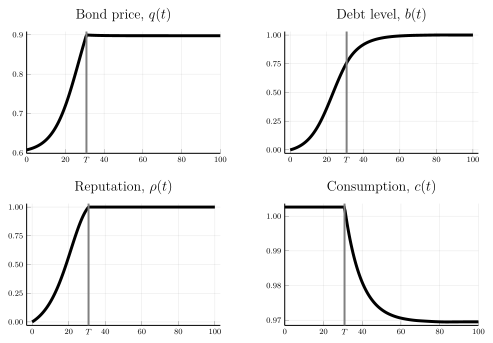

In [9]:
f1 = do_plots(sol)

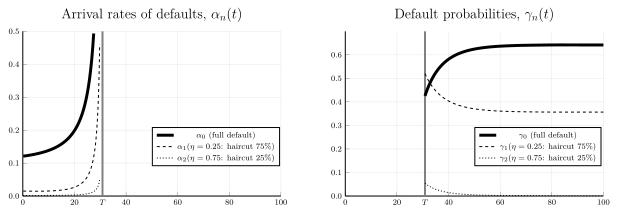

In [10]:
f2 = do_conditional_default_probability_plots(sol)

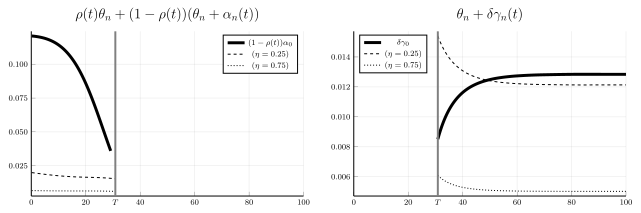

In [11]:
f3 = do_unconditional_default_probability_plots(sol)

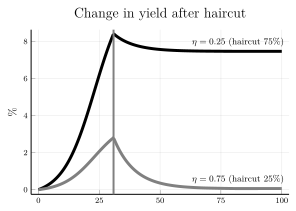

In [12]:
f4 = do_increase_in_yield_plots(sol)

### Exporting figures

In [13]:
savefig(f1, joinpath(@__DIR__, "..", "output", "basic_plot.pdf"))
savefig(f2, joinpath(@__DIR__, "..", "output", "conditional_plot.pdf"))
savefig(f3, joinpath(@__DIR__, "..", "output", "unconditional_plot.pdf"))
savefig(f4, joinpath(@__DIR__, "..", "output", "yields_plot.pdf"))